# Exploración de datos

Notebook para explorar los datos previavemente procesados y almacenados en *data_processed/data_processed.csv* 

Para obtener este dataset se utilizaron los notebooks que se encuentran en la carpeta *Extraccion_datos*.

1) Definición de cada atributo y sus características

2) Visualización

3) Estudio de correlaciones

4) Identificar mejoras a aplicar a los datos (transformaciones, datos extra, etc.). Conclusiones.

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
 
%matplotlib inline
plt.style.use('ggplot')

In [2]:
df=pd.read_csv('../data_processed/data_processed.csv',sep=';',index_col=False,parse_dates=['FECHA'])

In [3]:
pd.options.display.max_columns= None

In [4]:
df.head()

,FECHA,PERIODO,MES,WD,PRECIO_MD_ESP,ACOPLADO_FR,RESERVA_D-1,P48_EOLICA,P48_DEMANDA,POT_DISP_CARBON,P48_CARBON_D-1,NUM_PLANTAS_D-1,EMB_ANUALES,EMB_HIPERANUALES,RESERVA
0,2015-10-01,1,10,4,56.65,0,0,2196.1,24517.1,10060.7,7181.4,22,3714,4909,1
1,2015-10-01,2,10,4,53.50,0,0,2064.4,23168.6,10060.7,6771.7,22,3714,4909,0
2,2015-10-01,3,10,4,49.69,0,0,1866.5,22437.2,10060.7,6559.5,22,3714,4909,0
3,2015-10-01,4,10,4,49.10,0,0,1660.9,22281.3,10060.7,6560.4,23,3714,4909,0
4,2015-10-01,5,10,4,51.25,0,0,1373.9,21909.7,10060.7,6724.1,23,3714,4909,0


In [5]:
df.describe()

,PERIODO,MES,WD,PRECIO_MD_ESP,ACOPLADO_FR,RESERVA_D-1,P48_EOLICA,P48_DEMANDA,POT_DISP_CARBON,P48_CARBON_D-1,NUM_PLANTAS_D-1,EMB_ANUALES,EMB_HIPERANUALES,RESERVA
count,26301.000000,26301.000000,26301.000000,26301.000000,26301.000000,26301.000000,26301.000000,26301.000000,26301.000000,26301.000000,26301.000000,26301.000000,26301.000000,26301.000000
mean,12.501084,6.522300,4.080871,48.740019,0.247557,0.575073,5479.385506,28674.013003,8607.388400,4413.024957,13.704726,4627.927265,4154.811300,0.575567
std,6.921969,3.449043,2.020287,14.955317,0.431601,0.494341,3186.007150,4615.766551,745.633807,2218.821169,6.263835,1464.006360,1303.402024,0.494266
min,1.000000,1.000000,1.000000,2.060000,0.000000,0.000000,240.800000,17728.400000,5693.700000,546.000000,2.000000,2222.000000,2138.000000,0.000000
25%,7.000000,4.000000,2.000000,40.140000,0.000000,0.000000,3018.400000,24735.700000,8120.400000,2317.100000,8.000000,3429.000000,3137.000000,0.000000
50%,13.000000,7.000000,4.000000,49.550000,0.000000,1.000000,4822.700000,28921.700000,8679.100000,4636.600000,15.000000,4545.000000,4266.000000,1.000000
75%,19.000000,10.000000,6.000000,59.450000,0.000000,1.000000,7289.700000,32268.100000,9153.600000,6290.700000,19.000000,5726.000000,5004.000000,1.000000
max,24.000000,12.000000,7.000000,101.990000,1.000000,1.000000,16952.600000,41297.900000,10070.400000,8768.300000,25.000000,7105.000000,6472.000000,1.000000


In [6]:
df.dtypes

FECHA               datetime64[ns]
PERIODO                      int64
MES                          int64
WD                           int64
PRECIO_MD_ESP              float64
ACOPLADO_FR                  int64
RESERVA_D-1                  int64
P48_EOLICA                 float64
P48_DEMANDA                float64
POT_DISP_CARBON            float64
P48_CARBON_D-1             float64
NUM_PLANTAS_D-1              int64
EMB_ANUALES                  int64
EMB_HIPERANUALES             int64
RESERVA                      int64
dtype: object

In [7]:
df.isnull().any().any()  #comprobamos, aunque ya estaba testeado, que no hay NaN

False

## 1) Definición de cada atributo:

* **FECHA**: día de estudio. Formato %Y-%m-%d

* **PERIODO**: representa la hora del día expresado como la finalización de la hora de estudio. Es decir, el periodo 1 contiene la información del periodo comprendido entre las 00:00 y las 01:00

* **MES**: mes al que pertenece el día de estudio, de 1 a 12. No todos los meses son iguales. En electricidad se suele simplificar hablando de Qs (trimestres). Así, el Q1 que comprende los meses de enero, febrero y marzo, se suelen caracterizar por alta eolicidad, demanda (invierno), hidraulicidad, mientras que en los meses del Q3, julio, agosto, septiembre, la eolicidad es más baja, desciende la aportación hidráulica, etc. Es por ello que se ha seleccionado el mes como una de las características a tener en cuenta.


......

### El target es RESERVA: 

* 0 = Sube el intradiario, compro todo en el MD.

* 1 = Baja el intradiario, reservo parte de mi compra para comprarla más barata en el MI1.



### 1.1. Lo primero compruebo si los datos están desbalanceados o si tiene alguna tendencia temporal:

In [8]:
df['RESERVA'].value_counts(normalize=True)

1    0.575567
0    0.424433
Name: RESERVA, dtype: float64

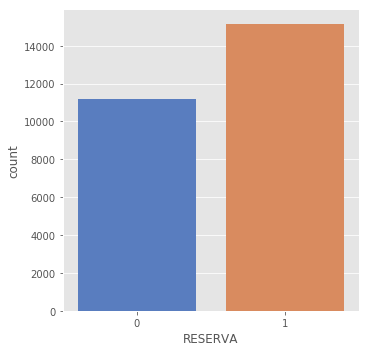

In [9]:
#Para usar sns.catplot es necesario contar con la última actualización de seaborn: v0.9.0

#conda update seaborn

sns.catplot('RESERVA',data=df,kind='count',palette='muted')
plt.show()

Aunque hay más horas donde baja el intradiario, está bastante equilibrado.

Compruebo si existe desbalanceo en algún año o de 1 año y otro. 

Me ayudo de 3 dataset distintos, cada uno un año hidráulico, y añado columna *ANHO* que representa el año hidráulico al que pertenecen:

*NOTA: El año hidráulico comienza en octubre y finaliza en septiembre, por considerarse octubre el primer mes de lluvias. Por ello nuestro dataset se inició en octubre 2015.*

In [10]:
df_anho=df.copy()  #Creamos copia de df

In [11]:
anho=pd.to_datetime(['2016-10-01','2017-10-01','2018-10-01'],format='%Y-%m-%d')
anho  #límite del año hidraúlico

DatetimeIndex(['2016-10-01', '2017-10-01', '2018-10-01'], dtype='datetime64[ns]', freq=None)

In [12]:
df_anho_1=df[df['FECHA']<anho[0]]
df_anho_2=df[(df['FECHA']>=anho[0])&(df['FECHA']<anho[1])]
df_anho_3=df[(df['FECHA']>=anho[1])]

In [13]:
#Función para crear año hidráulico
def anho_hidraulico(elem):
    if elem<anho[0]:
        return 1;
    elif elem<anho[1]:
        return 2;
    else:
        return 3;

In [14]:
df_anho['ANHO']=list(df_anho['FECHA'].map(anho_hidraulico))
df_anho.sample(10)  #Comprobamos correcto funcionamiento:

,FECHA,PERIODO,MES,WD,PRECIO_MD_ESP,ACOPLADO_FR,RESERVA_D-1,P48_EOLICA,P48_DEMANDA,POT_DISP_CARBON,P48_CARBON_D-1,NUM_PLANTAS_D-1,EMB_ANUALES,EMB_HIPERANUALES,RESERVA,ANHO
22386,2018-04-20,22,4,5,46.18,1,1,7938.9,31091.3,7894.2,2657.3,8,7076,4822,0,3
8103,2016-09-02,17,9,5,45.69,0,1,2124.2,35502.8,8817.2,7852.1,22,3765,4778,1,1
19669,2017-12-28,16,12,4,49.90,1,1,13781.2,31037.3,9505.0,1448.9,5,2617,2267,1,3
12094,2017-02-15,24,2,3,52.30,0,0,4874.8,28773.6,8031.5,5971.0,19,4613,3588,1,2
2240,2016-01-02,9,1,6,17.73,1,0,10514.8,22234.1,8744.0,978.5,4,5689,5538,1,1
18870,2017-11-25,9,11,6,53.16,1,0,8190.2,26359.7,7503.5,7225.8,21,2222,2182,1,3
1765,2015-12-13,14,12,7,47.59,0,1,4391.7,27748.6,9429.0,8431.4,23,3837,4807,1,1
6848,2016-07-12,10,7,2,43.52,0,1,3205.0,33928.8,8964.7,5608.3,15,5609,5791,1,1
7684,2016-08-16,6,8,2,44.45,0,1,2730.4,22178.1,7846.7,2062.2,7,4545,5182,0,1
11503,2017-01-22,9,1,7,65.10,1,0,5675.8,24439.9,7015.1,6004.8,20,2990,3363,0,2



Definimos también vector orden: El primer mes del año hidráulico es el 10 (octubre)

In [15]:
order=[10,11,12,1,2,3,4,5,6,7,8,9]

In [16]:
df_anho.groupby(['ANHO'])['RESERVA'].value_counts(normalize=True)*100

ANHO  RESERVA
1     1          58.226119
      0          41.773881
2     1          55.497203
      0          44.502797
3     1          58.945085
      0          41.054915
Name: RESERVA, dtype: float64

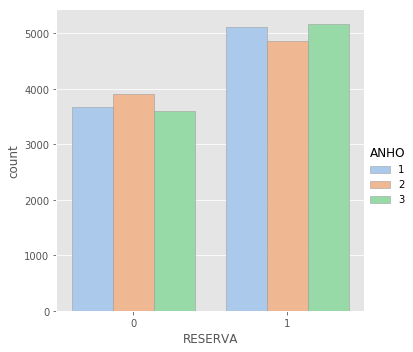

In [17]:
sns.catplot('RESERVA', hue='ANHO', kind='count',
            palette='pastel', edgecolor=".6",
            data=df_anho);

Aunque sí hay más proporción de horas en las que baja el precio del intradiario en todos los años, la diferencia no la considero significativa en ningún año (41% vs. 59% el que más). También, si se valoran individualmente los años, el resultado es análogo en los 3.

Por tanto, se concluye que **por años** el target RESERVA **no esta desbalanceado**.

¿Por meses?

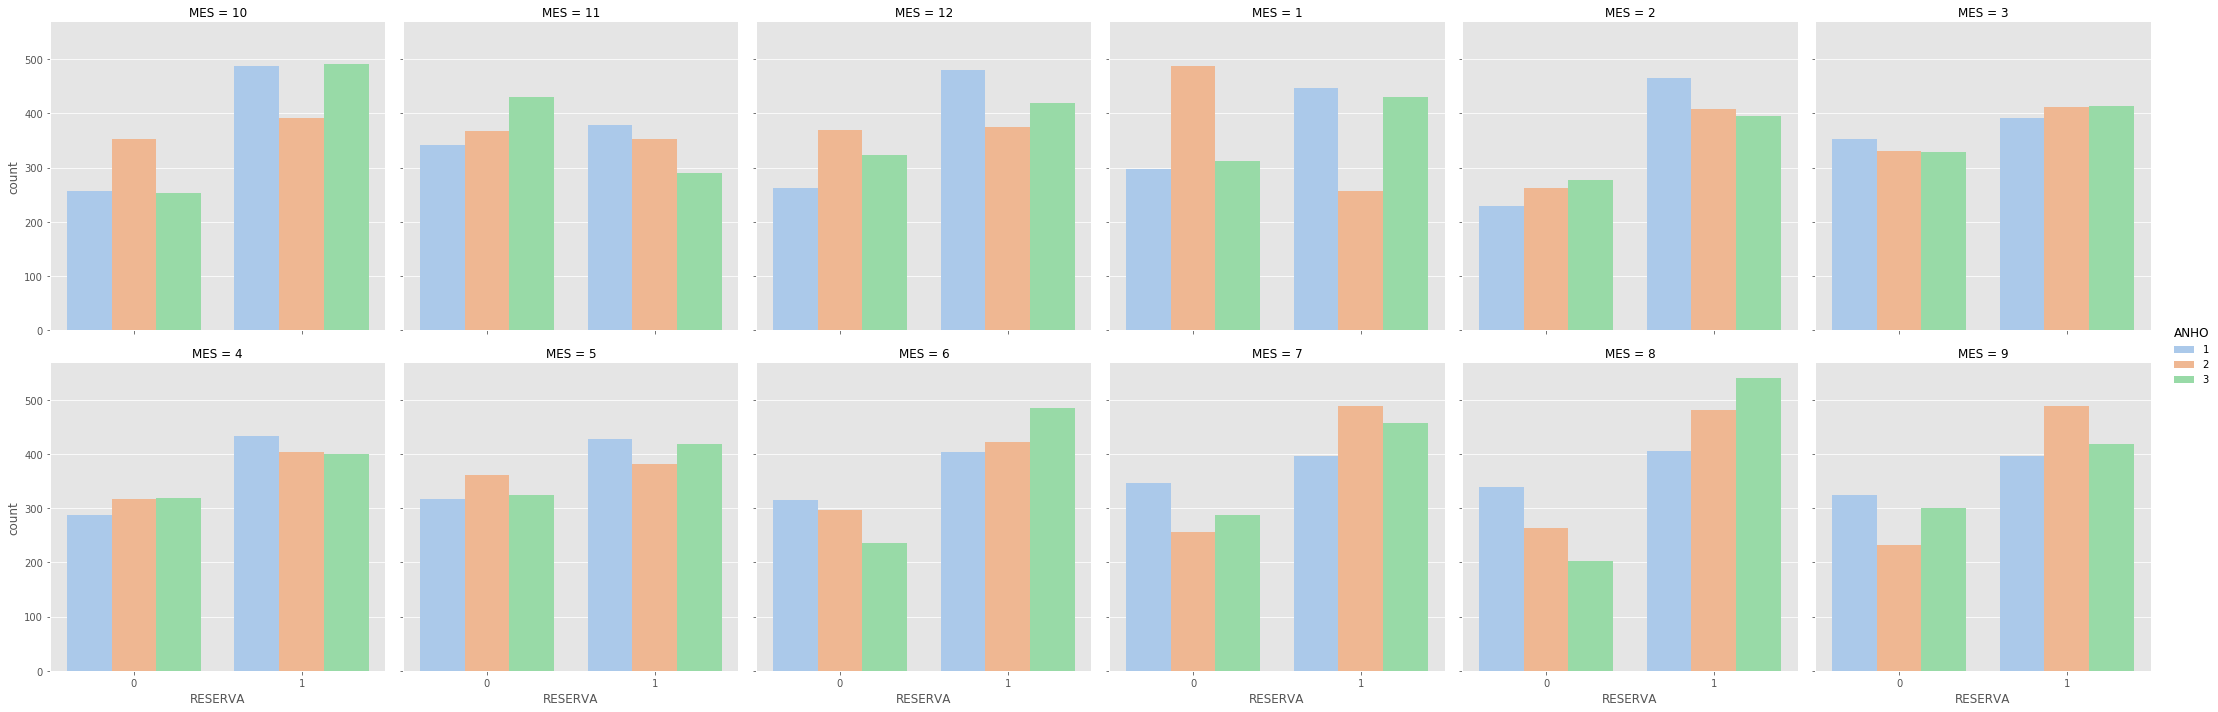

In [18]:
sns.catplot('RESERVA',data=df_anho,kind="count",hue="ANHO",col="MES",col_order=order,palette="pastel",col_wrap=6);

Sí hay meses donde se ha dado más un caso que otro *(oct15,feb16,ene17,sept17,junio18...)*, aunque sin un patrón repetitivo que indique desbalanceo de los datos. 

**Haré la validación del modelo n veces (con diferentes divisiones del train_set) para ajustar los hiperparámetros y evitar perder muestras importantes (cross-validation)**

          Aquí aparece la 1ª duda:

          DUDA: ¿Es el mes una feature a considerar en el modelo o va intrínseca en el resto de variables? Lo estudiaré mas adelante


#### Estudio de RESERVA en función de otras variables categóricas temporales: laboralidad (WD):

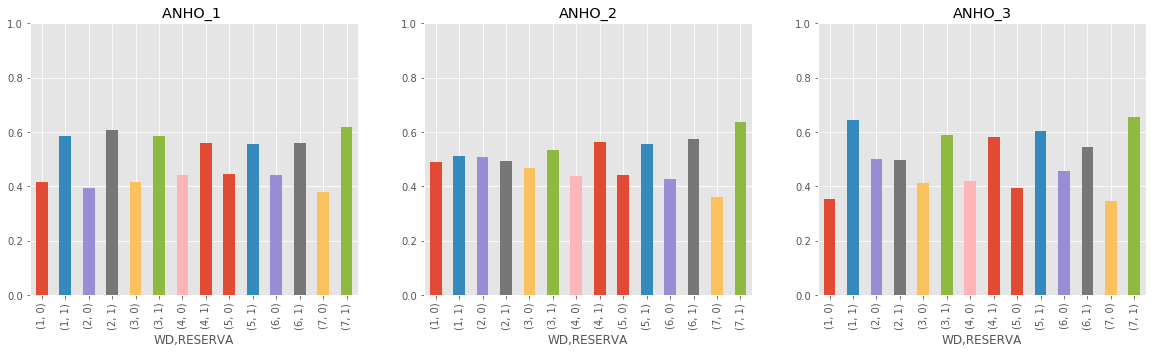

In [19]:
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.title("ANHO_1 ") 
plt.ylim(0,1)
df_anho_1.groupby('WD')['RESERVA'].value_counts(normalize=True,sort=False).plot(kind='bar')

plt.subplot(1,3,2)
plt.title('ANHO_2')
plt.ylim(0,1)
df_anho_2.groupby('WD')['RESERVA'].value_counts(normalize=True,sort=False).plot(kind='bar')

plt.subplot(1,3,3)
plt.title('ANHO_3')
plt.ylim(0,1)
df_anho_3.groupby('WD')['RESERVA'].value_counts(normalize=True,sort=False).plot(kind='bar')

plt.show()

En los gráficos superiores se observa como en los 3 años, el domingo tiene una clara mayor proporción de horas de bajada del intradiario. 

El resto de días no presentan un comportamiento evidente visualmente. **Sí encuentro importante considerar el weekday como feature de entrada**.

### 1.2. ¿Es correcto, a priori, utilizar un dataset de 3 años?

Analizo cómo se comportaron las distintas variables cada año, para valorar si con 3 años se consigue abarcar diferentes escenarios que se puedan presentar en el futuro o si con un dataset más pequeño sería suficiente.

Además, agrupo por dato mensual para evaluar si es correcto utilizarlo como *feature* o va intrínseco en el comportamiento del resto de variables tras la duda anterior.

In [20]:
#Divido entre 1000 para expresarlo en GWh mensuales
df_mensual_1=df_anho_1[['P48_EOLICA','P48_DEMANDA','P48_CARBON_D-1','MES']].groupby('MES',sort=False).sum()/1000
df_mensual_2=df_anho_2[['P48_EOLICA','P48_DEMANDA','P48_CARBON_D-1','MES']].groupby('MES',sort=False).sum()/1000
df_mensual_3=df_anho_3[['P48_EOLICA','P48_DEMANDA','P48_CARBON_D-1','MES']].groupby('MES',sort=False).sum()/1000

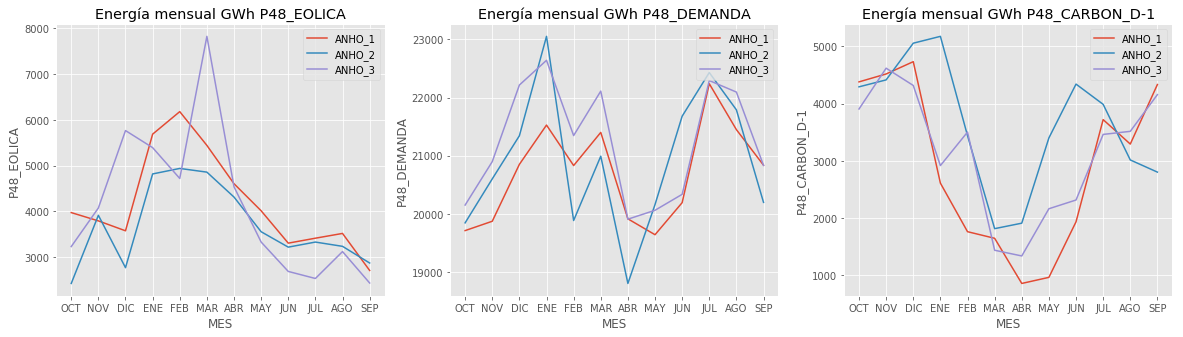

In [21]:
#Cambio los nombres de los ejes a string para que no me ordene automáticamente y no lleve a error: 
#Ejemplo: ANHO_1 va de octubre'15 a sept'16

df_mensual_1.rename(index={10:'OCT',11:'NOV',12:'DIC',1:'ENE',2:'FEB',3:'MAR',4:'ABR',5:'MAY',6:'JUN',7:'JUL',8:'AGO',9:'SEP'},inplace=True)
df_mensual_2.rename(index={10:'OCT',11:'NOV',12:'DIC',1:'ENE',2:'FEB',3:'MAR',4:'ABR',5:'MAY',6:'JUN',7:'JUL',8:'AGO',9:'SEP'},inplace=True)
df_mensual_3.rename(index={10:'OCT',11:'NOV',12:'DIC',1:'ENE',2:'FEB',3:'MAR',4:'ABR',5:'MAY',6:'JUN',7:'JUL',8:'AGO',9:'SEP'},inplace=True)

plt.figure(figsize=(20,5))
for i,col in enumerate(['P48_EOLICA','P48_DEMANDA','P48_CARBON_D-1']):
    plt.subplot(1,3,i+1)
    plt.title("Energía mensual GWh " + col) 
    plt.plot(df_mensual_1[col],label='ANHO_1')
    plt.plot(df_mensual_2[col],label='ANHO_2')
    plt.plot(df_mensual_3[col],label='ANHO_3')
    plt.legend(loc="upper right")
    plt.xlabel("MES")    
    plt.ylabel(col)   
plt.show()


De momento sí se observa un perfil mensual en el comportamiento de las variables estudiadas.

Sin embargo, aunque este comportamiento es análogo cada año en cuanto a perfil, el nivel de producción varía considerablemente de un año a otro algunos meses. **De momento decido quedarme con los 3 años y sigo contemplando la variable MES**

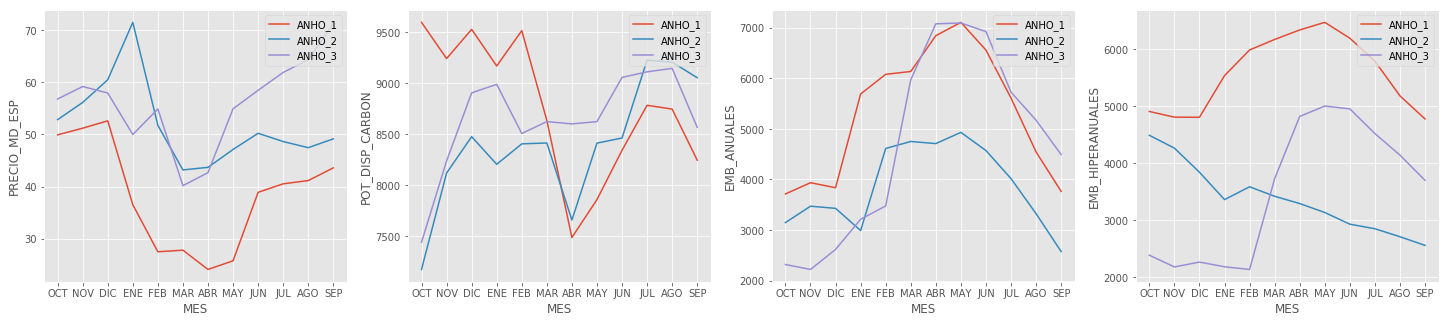

In [22]:
df_mensual_1mean=df_anho_1[['POT_DISP_CARBON','EMB_ANUALES','EMB_HIPERANUALES','PRECIO_MD_ESP','MES']].groupby('MES',sort=False).mean()
df_mensual_2mean=df_anho_2[['POT_DISP_CARBON','EMB_ANUALES','EMB_HIPERANUALES','PRECIO_MD_ESP','MES']].groupby('MES',sort=False).mean()
df_mensual_3mean=df_anho_3[['POT_DISP_CARBON','EMB_ANUALES','EMB_HIPERANUALES','PRECIO_MD_ESP','MES']].groupby('MES',sort=False).mean()

df_mensual_1mean.rename(index={10:'OCT',11:'NOV',12:'DIC',1:'ENE',2:'FEB',3:'MAR',4:'ABR',5:'MAY',6:'JUN',7:'JUL',8:'AGO',9:'SEP'},inplace=True)
df_mensual_2mean.rename(index={10:'OCT',11:'NOV',12:'DIC',1:'ENE',2:'FEB',3:'MAR',4:'ABR',5:'MAY',6:'JUN',7:'JUL',8:'AGO',9:'SEP'},inplace=True)
df_mensual_3mean.rename(index={10:'OCT',11:'NOV',12:'DIC',1:'ENE',2:'FEB',3:'MAR',4:'ABR',5:'MAY',6:'JUN',7:'JUL',8:'AGO',9:'SEP'},inplace=True)


plt.figure(figsize=(25,5))
for i,col in enumerate(['PRECIO_MD_ESP','POT_DISP_CARBON','EMB_ANUALES','EMB_HIPERANUALES']):
    plt.subplot(1,4,i+1)
    plt.plot(df_mensual_1mean[col],label='ANHO_1')
    plt.plot(df_mensual_2mean[col],label='ANHO_2')
    plt.plot(df_mensual_3mean[col],label='ANHO_3')
    plt.legend(loc="upper right")
    plt.xlabel("MES")    
    plt.ylabel(col)   
plt.show()

* La **Potencia Disponible de Carbón** va asociada a las paradas programadas de las plantas. Parece que suelen llevarse a cabo cada n meses.

* Vemos por años como ha variado la situación de los embalses. Se distinguen dos tipos de embalses por ser distinta la disponibilidad de la aportación al mix de generación que tienen. Por ello no se juntan ambas variables en una. Se definen:

    * **Embalses anuales:** Embalses con una capacidad de regulación de sus reservas inferior a un año.
    * **Embalses hiperanuales:** Embalses con una capacidad de regulación de sus reservas superior a un año.

El vaciado y llenado de los embalses anuales, como se corrobora en el gráfico, va muy ligado al mes en el que se encuentra aunque los niveles alcanzados dependerán de la característica del año (húmedo/seco) y del nivel del que partían el año anterior.

Los embalses hiperanuales dependen mucho del momento de lluvias. En marzo 2018, tras un año 2017 caracterizado como seco (rampa descendiente ANHO_2) y un comienzo de año hidráulico sin pretensión, comienza el periodo de lluvias generalizado en toda España y con él el llenado de los embalses hiperanuales.

Por este motivo, se cogieron 3 años hidráulicos para intentar abarcar situaciones de hidraulicidad distintas: 

*2016 tenía un nivel elevado de hidráulica porque partía de años húmedos (2013, 2014 principalmente), pero a final de año comienzan las consecuencias de un año hidráulico seco que continúa durante 2017 y no se recupera hasta marzo de 2018.*


* Por último, el valor del **Precio_MD** medio mensual varía mucho de unos meses a otros y de un año a otro. Lo analizo más en detalle.

### 1.2.1. Análisis de la variable PRECIO_MD_ESP: OUTLIERS

Se analiza esta variable más en profundidad. Posibles outliers y comportamiento de los mismos en cuanto a si después sube o baja el precio en los MMII (columna RESERVA) para tomar decisiones sobre mantenerlos o no.

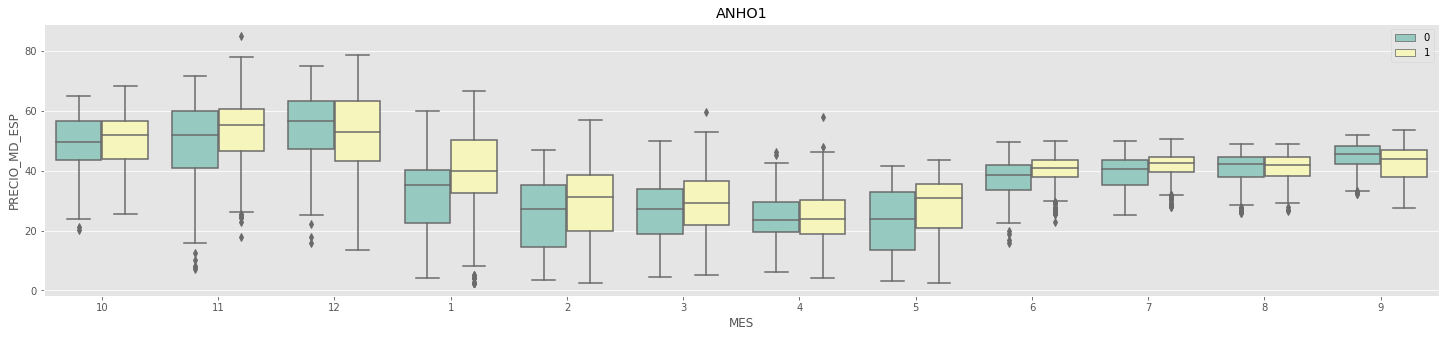

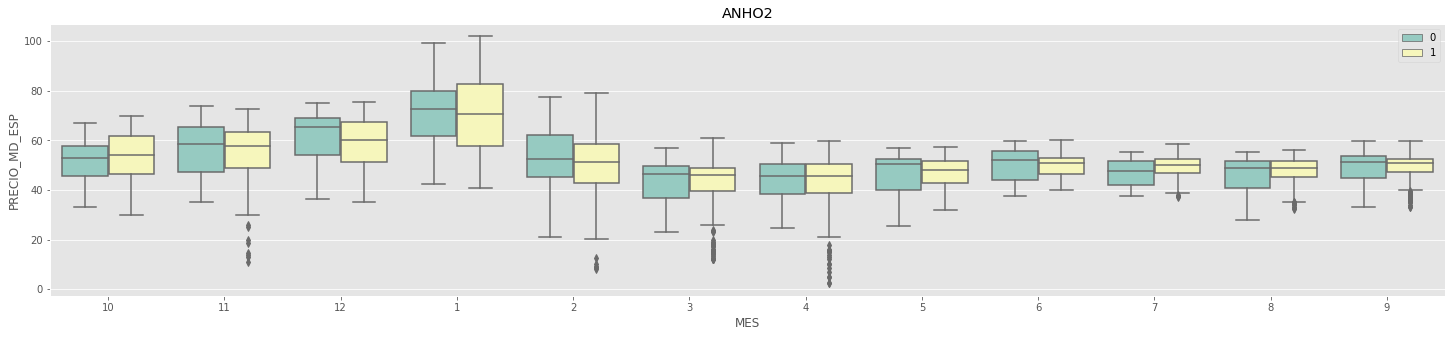

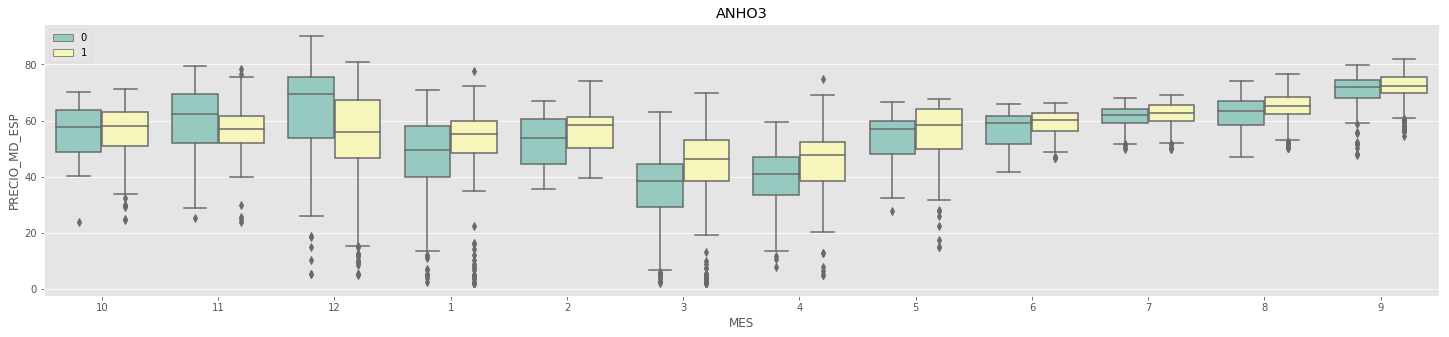

In [23]:
plt.figure(figsize=(25,5))
plt.title("ANHO1")
sns.boxplot(x="MES", y="PRECIO_MD_ESP", hue="RESERVA",order=order, data=df_anho_1,palette="Set3")
plt.legend(loc="best")
plt.show()

plt.figure(figsize=(25,5))
plt.title("ANHO2")
sns.boxplot(x="MES", y="PRECIO_MD_ESP",hue="RESERVA",order=order, data=df_anho_2,palette="Set3")
plt.legend(loc="best")
plt.show()

plt.figure(figsize=(25,5))
plt.title("ANHO3")
sns.boxplot(x="MES", y="PRECIO_MD_ESP", hue="RESERVA", order= order, data=df_anho_3,palette="Set3")
plt.legend(loc="best")
plt.show()

En todos los años parece existir más outliers de precios de MD bajos. Sin embargo, en los gráficos de cajas y bigotes representados, no se aprecia que impliquen una subida o bajada de los MMII directamente. Compruebo si es correcta esta afirmación:

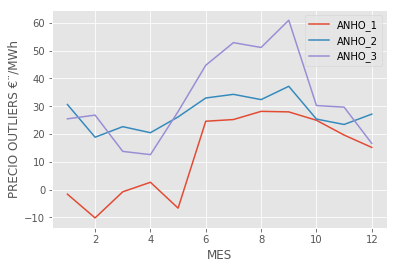

In [102]:
#Calculamos el IQR. Todo lo que esté por debajo de Q1-1.5IQR lo considero outlier (definición estadística)

IQR_1=df_anho_1[['PRECIO_MD_ESP','MES']].groupby('MES').quantile(0.75)-df_anho_1[['PRECIO_MD_ESP','MES']].groupby('MES').quantile(0.25)
IQR_2=df_anho_2[['PRECIO_MD_ESP','MES']].groupby('MES').quantile(0.75)-df_anho_2[['PRECIO_MD_ESP','MES']].groupby('MES').quantile(0.25)
IQR_3=df_anho_3[['PRECIO_MD_ESP','MES']].groupby('MES').quantile(0.75)-df_anho_3[['PRECIO_MD_ESP','MES']].groupby('MES').quantile(0.25)

Q1_1=df_anho_1[['PRECIO_MD_ESP','MES']].groupby('MES').quantile(0.25)
Q1_2=df_anho_2[['PRECIO_MD_ESP','MES']].groupby('MES').quantile(0.25)
Q1_3=df_anho_3[['PRECIO_MD_ESP','MES']].groupby('MES').quantile(0.25)

out_1=Q1_1-1.5*IQR_1
out_2=Q1_2-1.5*IQR_2
out_3=Q1_3-1.5*IQR_3


plt.plot(out_1,label='ANHO_1')
plt.plot(out_2,label='ANHO_2')
plt.plot(out_3,label='ANHO_3')
plt.legend(loc="upper right")
plt.xlabel("MES")    
plt.ylabel("PRECIO OUTLIERS €¨/MWh") 
plt.show()

Los precios considerados outliers en el ANHO 1 son mucho más bajos que los considerados outliers en los otros dos años -> Distintos escenarios de precios en los 3 años.

In [68]:
df_subset_1=[]
for k,v in enumerate(df_anho_1['MES']):
    mes=v
    precio= df_anho_1['PRECIO_MD_ESP'].iloc[k]
    reserva=df_anho_1['RESERVA'].iloc[k]
    if precio < out_1['PRECIO_MD_ESP'].loc[mes]:
        df_subset_1.append([mes,precio,reserva])
df_subset_1=pd.DataFrame(df_subset_1,columns=['MES','PMD','RESERVA'])

df_subset_2=[]
for k,v in enumerate(df_anho_2['MES']):
    mes=v
    precio= df_anho_2['PRECIO_MD_ESP'].iloc[k]
    reserva=df_anho_2['RESERVA'].iloc[k]
    if precio < out_2['PRECIO_MD_ESP'].loc[mes]:
        df_subset_2.append([mes,precio,reserva])
df_subset_2=pd.DataFrame(df_subset_2,columns=['MES','PMD','RESERVA'])

df_subset_3=[]
for k,v in enumerate(df_anho_3['MES']):
    mes=v
    precio= df_anho_3['PRECIO_MD_ESP'].iloc[k]
    reserva=df_anho_3['RESERVA'].iloc[k]
    if precio < out_3['PRECIO_MD_ESP'].loc[mes]:
        df_subset_3.append([mes,precio,reserva])
df_subset_3=pd.DataFrame(df_subset_3,columns=['MES','PMD','RESERVA'])

In [69]:
print(df_subset_1['RESERVA'].value_counts(normalize=True,sort=False))
print(df_subset_2['RESERVA'].value_counts(normalize=True,sort=False))
print(df_subset_3['RESERVA'].value_counts(normalize=True,sort=False))

0    0.787234
1    0.212766
Name: RESERVA, dtype: float64
0    0.306122
1    0.693878
Name: RESERVA, dtype: float64
0    0.508091
1    0.491909
Name: RESERVA, dtype: float64


In [71]:
(df_subset_1.groupby('MES')['PMD'].describe(),df_subset_2.groupby('MES')['PMD'].describe(),df_subset_3.groupby('MES')['PMD'].describe())

(     count       mean       std    min      25%     50%      75%    max
 MES                                                                    
 6     16.0  22.028750  2.638466  16.00  21.9050  22.765  23.7475  24.51
 8     14.0  26.877143  0.572316  25.97  26.5925  26.900  27.1250  27.80
 9      1.0  27.500000       NaN  27.50  27.5000  27.500  27.5000  27.50
 10     4.0  22.435000  2.088197  20.15  20.9300  22.595  24.1000  24.40
 11     9.0  12.706667  4.524909   7.20   8.0000  12.400  16.6000  18.00
 12     3.0  13.650000  0.251595  13.49  13.5050  13.520  13.7300  13.94,
      count       mean       std    min      25%     50%      75%    max
 MES                                                                    
 2      6.0   9.513333  1.565103   8.00   8.8600   8.860   9.7900  12.40
 3     25.0  15.061200  2.449352  12.00  12.4000  15.000  17.2600  20.00
 4     17.0  10.858824  5.028376   2.30   7.0900  12.120  15.0400  18.00
 5      2.0  25.430000  0.000000  25.43  25.4300  

Anteriormente se veía como predominaban las horas de bajada de precio del intradiario frente a las que subían, aunque la diferencia no era lo suficientemente grande como para considerar mi dataset desbalanceado hacia ese lado.

En los casos de los precios del MD extremos a la baja, se corportan de manera diferente un año y otro: 

El primer año, donde el valor *OUTLIER* es más bajo, sí se observa una tendencia clara de subida del intradiario (78%) a ese nivel. Sin embargo, la situación se da completamente la vuelta en el ANHO_2 y queda equilibrado en el ANHO_3. Es cierto que el precio máximo que se considera outlier es muy superior en el ANHO_3 que en el ANHO_1. 

Por tanto parece que ante precios extremos a la baja, sí pueda subir claramente el intradiario, pero en absoluto, valores muy bajos independientemente del mes/año en el que te encuentres. Esto dato lo interpreto como que el nivel del PRECIO_MD_ESP puede ser importante en mi modelo.

Otro dato a comentar es que el número de outliers es muy superior el 3º año frente al resto.

**Con todo esto, decido mantener los outliers en mi dataset**.

**NOTA: Tendré que tener en cuenta a la hora de entrenar el modelo, que el ANHO_1 recoge precios del mercado diario muy inferiores a los siguientes años.**

**Considero importante la temporalidad**

### 1.2.2. Análisis de la variable PRECIO_MD_ESP con otras variables: ACOPLADO FR

El precio del MD está muy influenciado por el precio del mercado diario francés gracias a la interconexión que permite un flujo de energía entre ambos países.

Cuando ambos países están acoplados, el precio de la hora es el mismo, y todavía está disponible más capacidad en esa misma dirección para que fluya energía del país más barato al más caro. Si la interconexión se satura en un sentido, ambos mercados se separan.

Desde el punto de vista del mercado intradiario, con ambos mercados acoplados Francia se comportaría como una central generadora más (cuando Precio FR < Precio ESP) o un consumidor en el caso opuesto, por eso se considera en este dataset.

Desde octubre'15 se duplicó la capacidad comercial de la misma hasta los 2.800 MW y el objetivo es llegar a los 10.000 MW exigidos por la UE para 2020 gracias a la nueva interconexión submarina por el Golfo de Bizkaia.

        Más info: https://www.ree.es/es/red21/refuerzo-de-las-interconexiones

Como en el dataset ya disponíamos de la máxima capacidad (salvo indisponibilidades o mantenimientos), no es necesario desagregar por años.

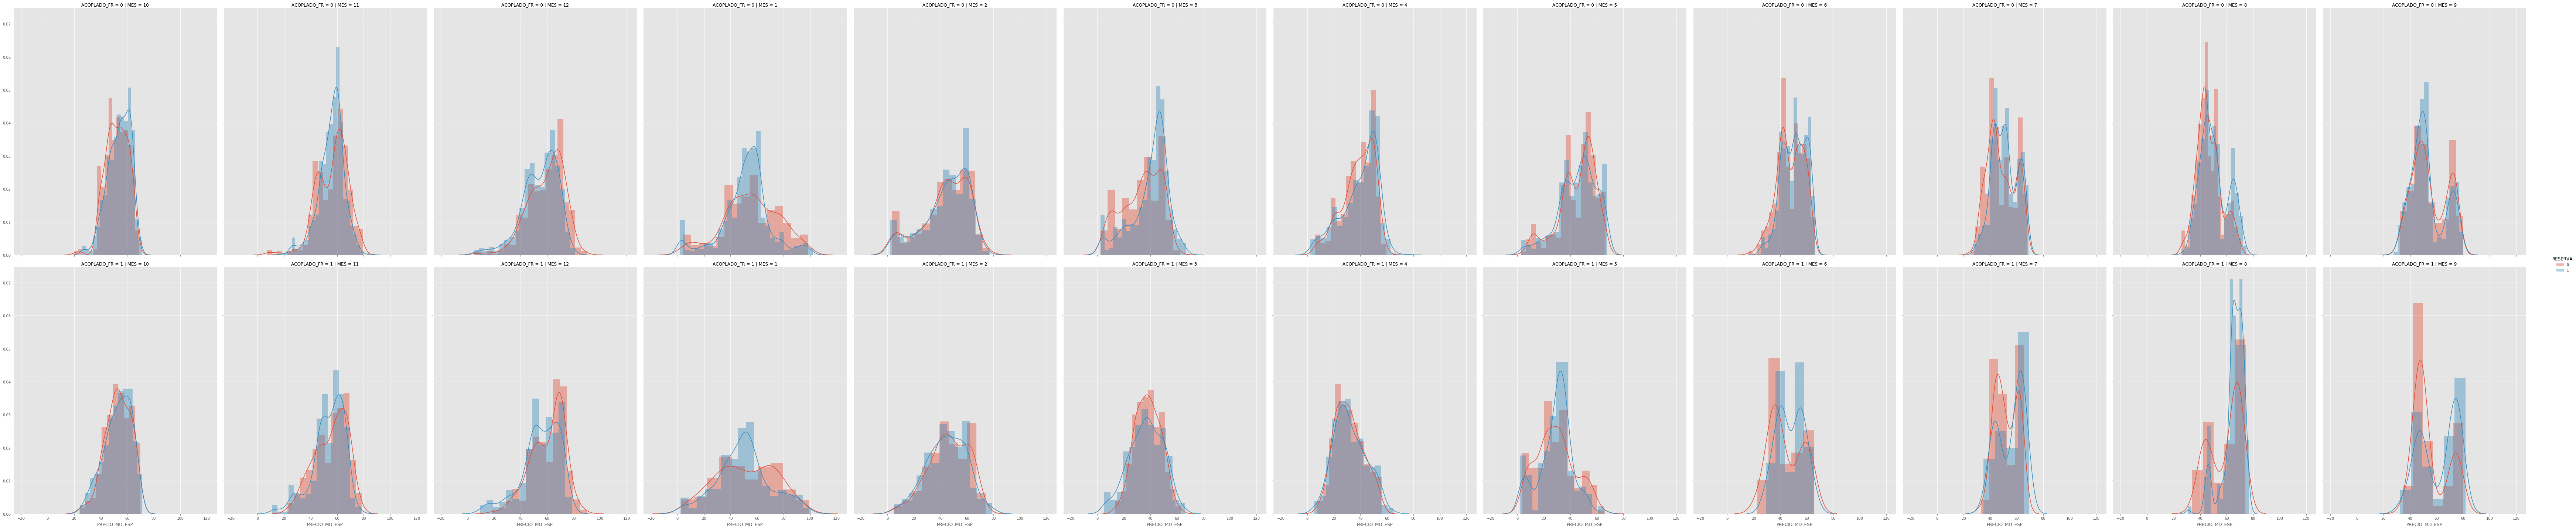

In [108]:
g = sns.FacetGrid(df_anho, col='MES', hue= 'RESERVA', row='ACOPLADO_FR',col_order=order,height=10,aspect=.8)
g.map(sns.distplot, 'PRECIO_MD_ESP',kde=True).add_legend();

In [98]:
df_anho.groupby('ACOPLADO_FR')['FECHA'].count()/len(df_anho['FECHA'])*100

ACOPLADO_FR
0    75.244287
1    24.755713
Name: FECHA, dtype: float64

La distribución del precio horario del MD de España es más apuntada cuando no está acoplado con Francia.

El número de horas con acoplamiento de ambos países tan solo es un 25%.

In [100]:
df_anho.groupby('ACOPLADO_FR')['RESERVA'].value_counts(normalize=True)

ACOPLADO_FR  RESERVA
0            1          0.584740
             0          0.415260
1            1          0.547689
             0          0.452311
Name: RESERVA, dtype: float64

### 1.4. Estudio de la distribución de las variables

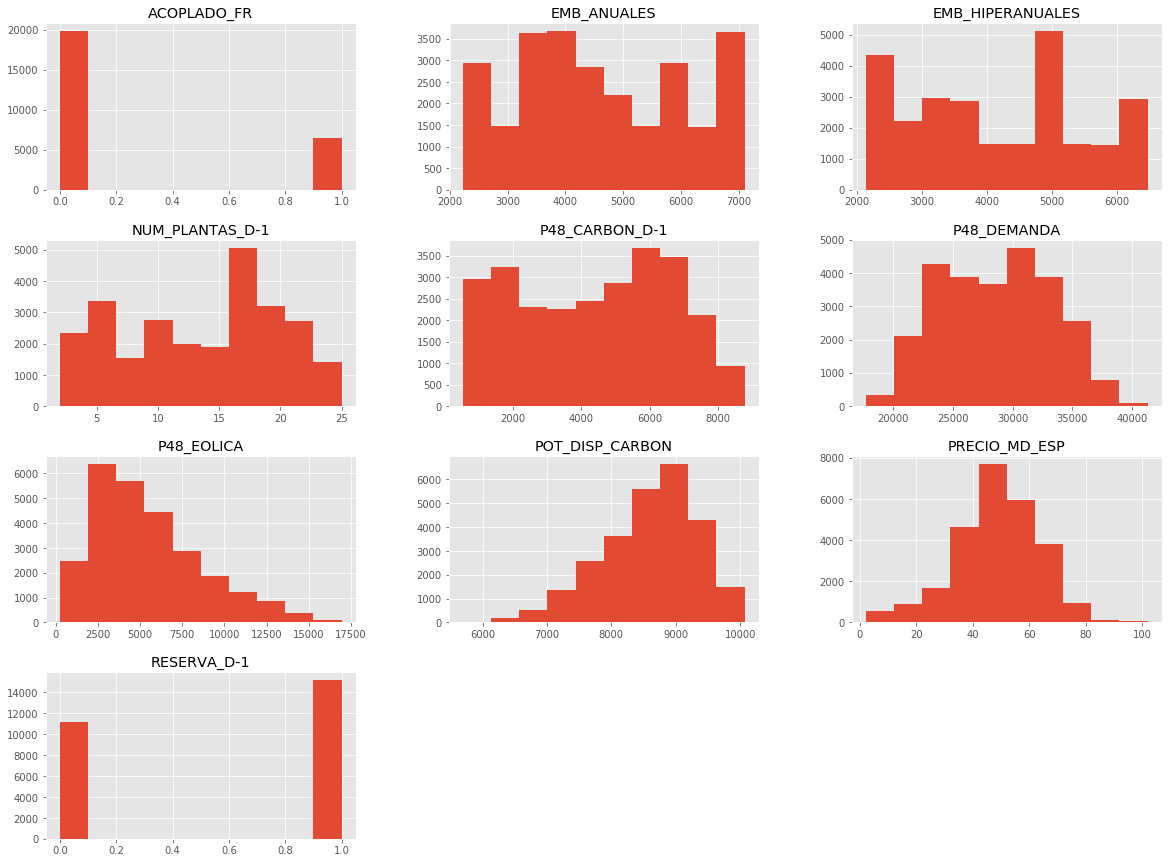

In [33]:
df.drop(['RESERVA','MES','PERIODO','WD'],axis=1).hist(figsize=(20,15))
plt.show()

/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


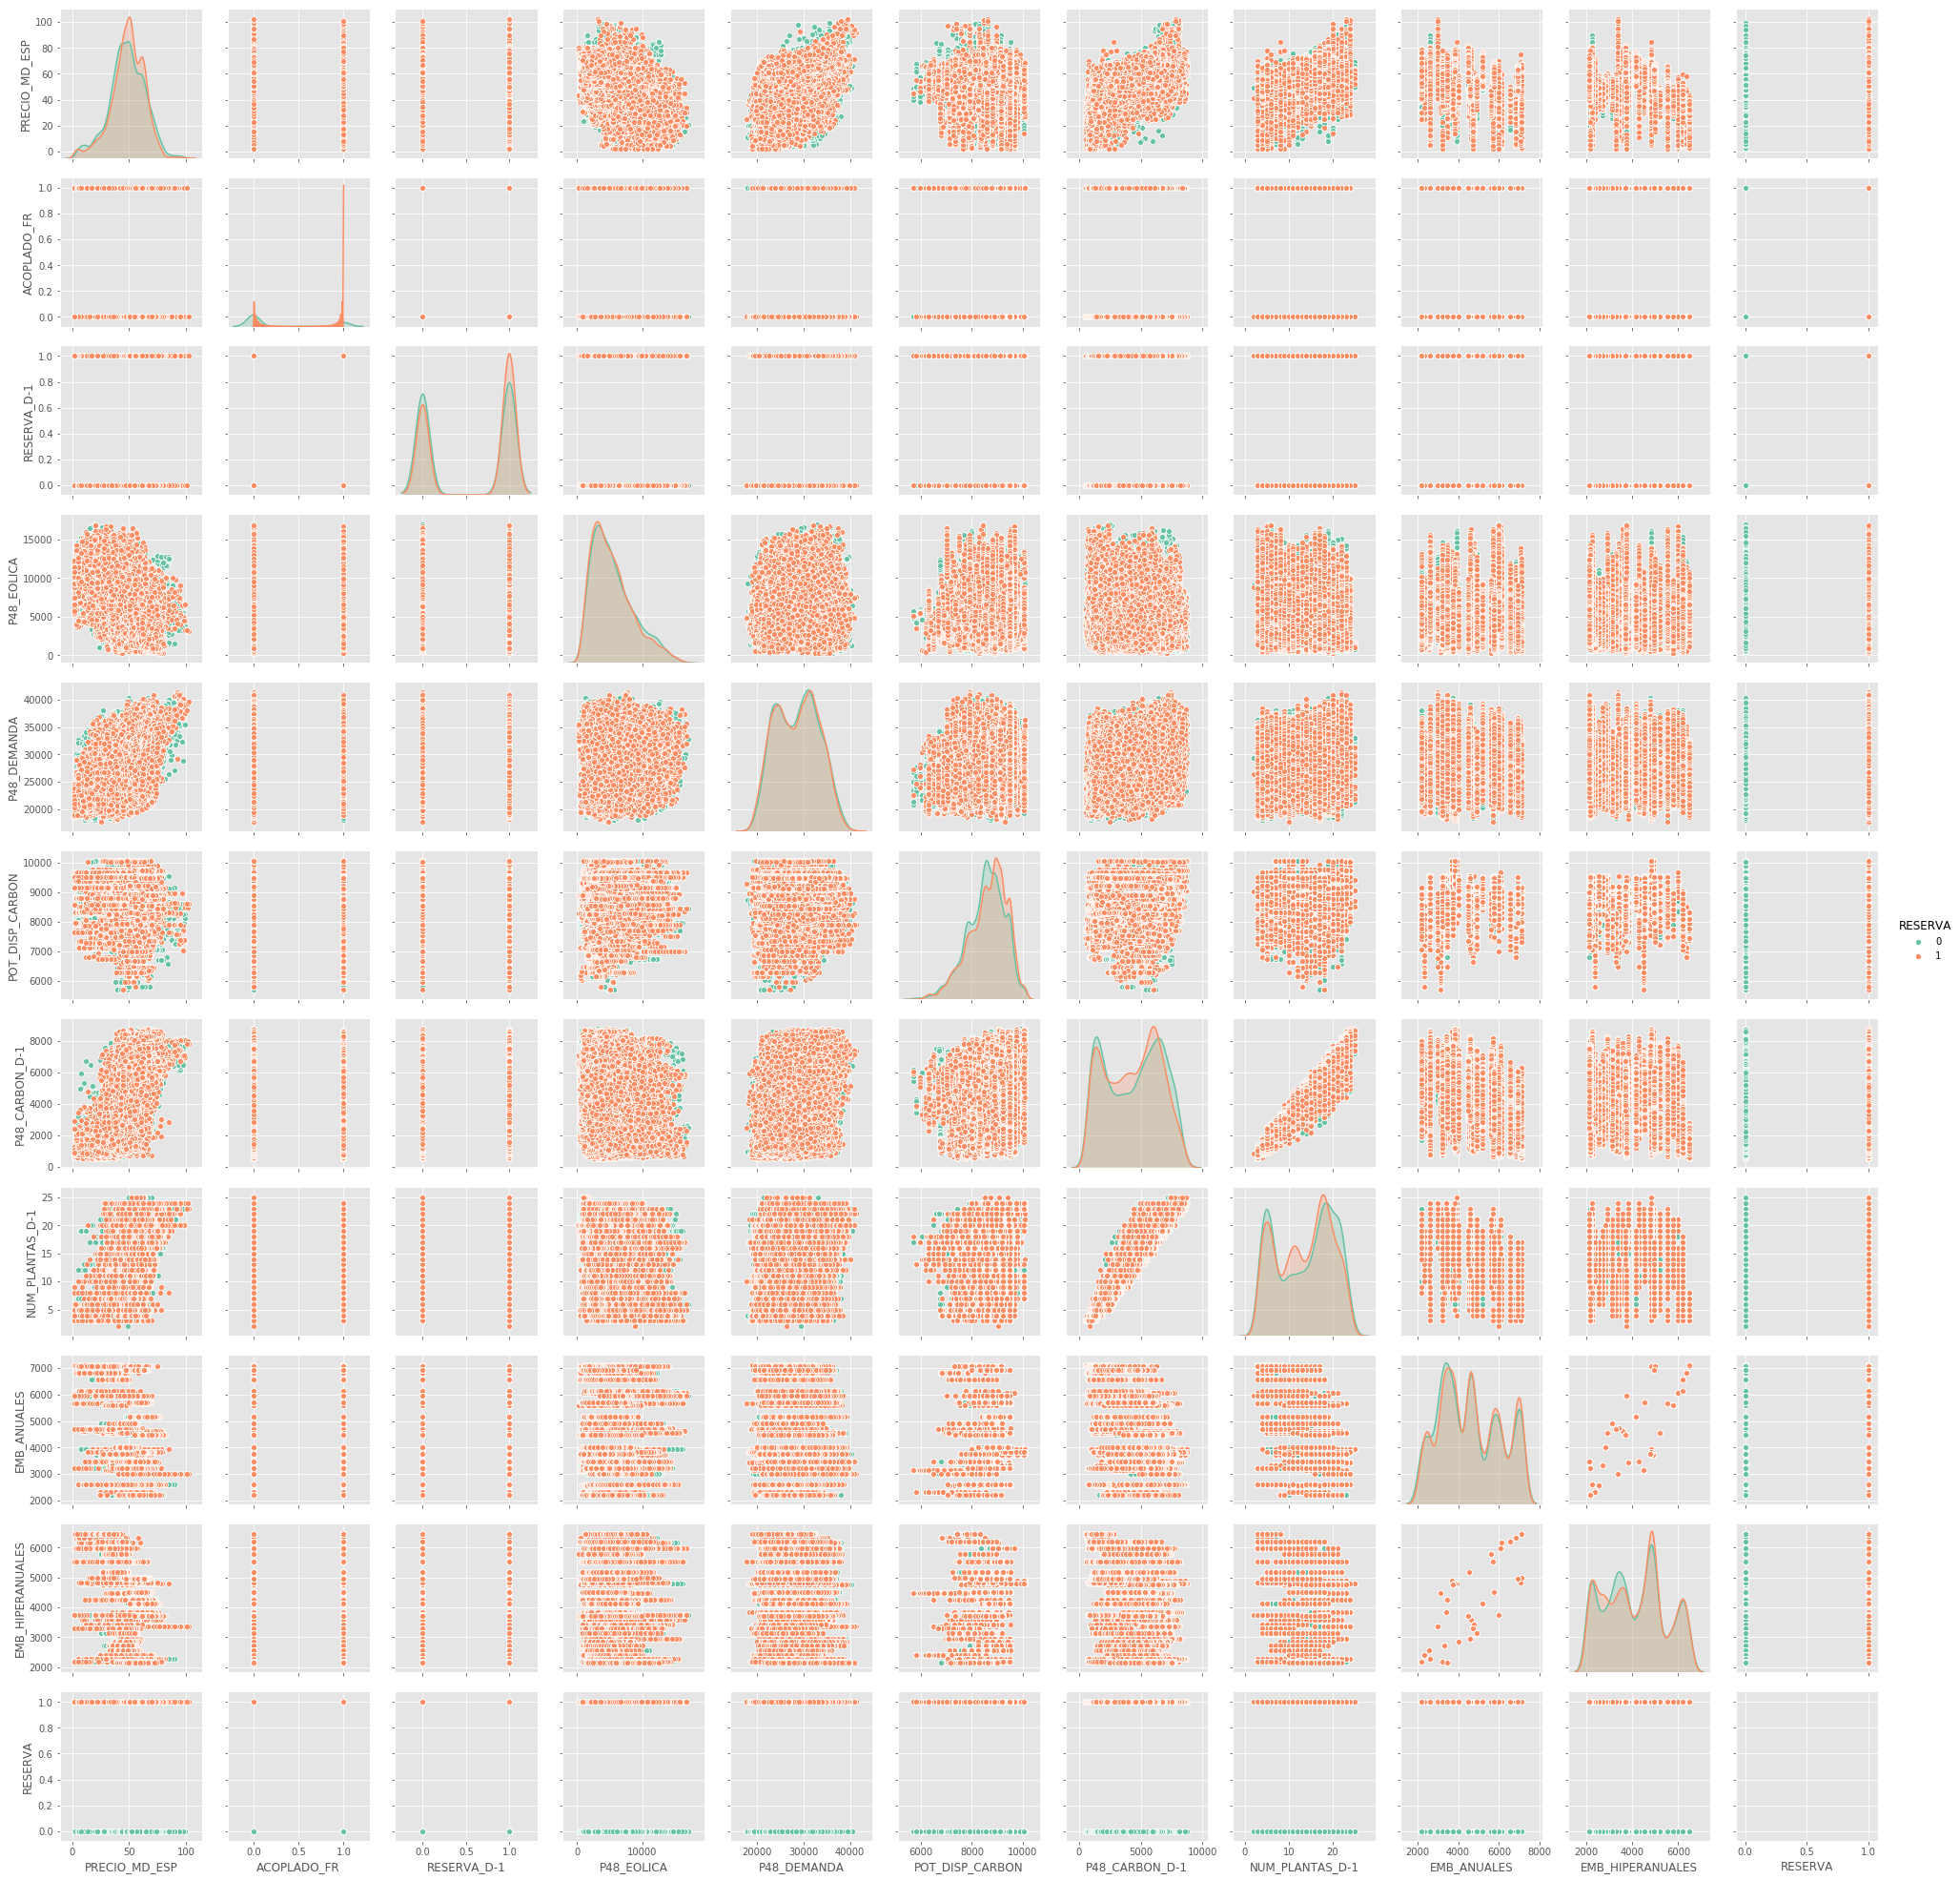

In [41]:
sns.pairplot(df_anho.drop(['MES','PERIODO','ANHO','WD'],axis=1),hue='RESERVA',palette="Set2")
plt.show()

### 1.5. Estudio correlaciones

In [29]:
correlations=df.corr()

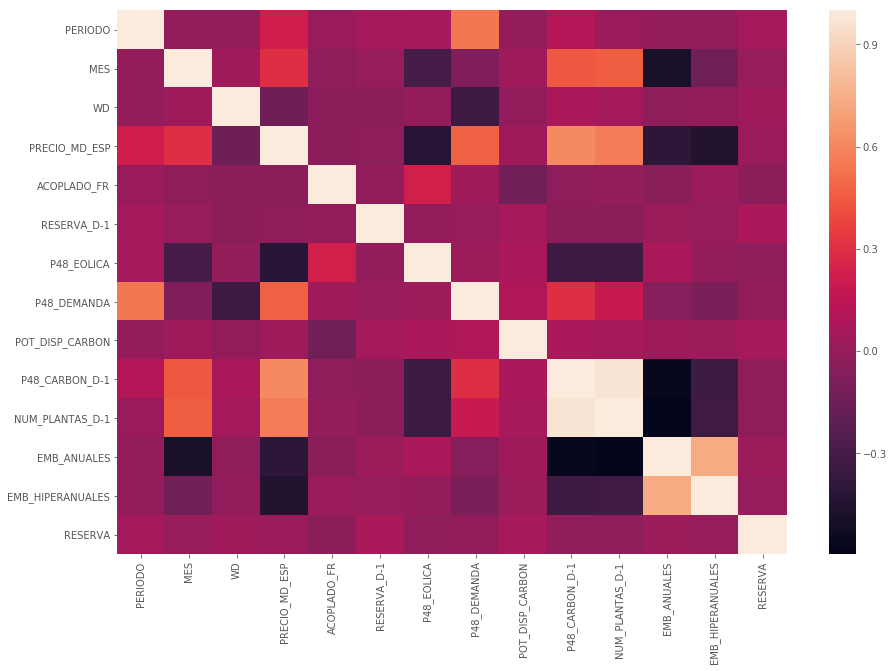

In [34]:
plt.figure(figsize=(15,10))
sns.heatmap(data=correlations)
plt.show()